In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sage.plot.plot3d.parametric_surface import ParametricSurface
import plotly.graph_objects as go
import plotly.express as px
from scipy.optimize import fsolve
from sympy import symbols, Eq, solve

In [2]:
import requests

climate_api = "https://api.mosqlimate.org/api/datastore/climate/"

page = 1 # total amount of pages is returned in the request
per_page = 100
pagination = f"?page={page}&per_page={per_page}&"
filters = "start=%s&end=%s" % ("2004-01-01", "2008-12-31")

resp = requests.get(climate_api + pagination + filters)

# Or you can add a geocode to the filters
geocode = 1302603
resp = requests.get(
    climate_api + 
    pagination + 
    filters +
    f"&geocode={geocode}"
)

items = resp.json()["items"] # JSON data in dict format
#total_items = resp.json()["total_items"] # JSON data in dict format
resp.json()["pagination"] # Pagination*

{'items': 100,
 'total_items': 1784,
 'page': 1,
 'total_pages': 18,
 'per_page': 100}

In [3]:
items

[{'date': '2004-01-01',
  'geocodigo': 1302603,
  'temp_min': 24.7052,
  'temp_med': 26.7748,
  'temp_max': 30.5519,
  'precip_min': 0.0,
  'precip_med': 0.7406,
  'precip_max': 3.0196,
  'precip_tot': 5.9251,
  'pressao_min': 0.9951,
  'pressao_med': 0.998,
  'pressao_max': 1.0012,
  'umid_min': 75.0331,
  'umid_med': 87.1228,
  'umid_max': 94.9243},
 {'date': '2004-01-02',
  'geocodigo': 1302603,
  'temp_min': 24.585,
  'temp_med': 26.8201,
  'temp_max': 30.1501,
  'precip_min': 0.0212,
  'precip_med': 0.7749,
  'precip_max': 3.479,
  'precip_tot': 6.1993,
  'pressao_min': 0.9937,
  'pressao_med': 0.9971,
  'pressao_max': 0.999,
  'umid_min': 74.2346,
  'umid_med': 86.2345,
  'umid_max': 95.9302},
 {'date': '2004-01-03',
  'geocodigo': 1302603,
  'temp_min': 24.2967,
  'temp_med': 26.216,
  'temp_max': 28.7951,
  'precip_min': 0.0028,
  'precip_med': 0.541,
  'precip_max': 1.0341,
  'precip_tot': 4.3277,
  'pressao_min': 0.9933,
  'pressao_med': 0.9962,
  'pressao_max': 0.9981,
  'um

In [4]:
df = pd.DataFrame(items)
df

,date,geocodigo,temp_min,temp_med,temp_max,precip_min,precip_med,precip_max,precip_tot,pressao_min,pressao_med,pressao_max,umid_min,umid_med,umid_max
0,2004-01-01,1302603,24.7052,26.7748,30.5519,0.0000,0.7406,3.0196,5.9251,0.9951,0.9980,1.0012,75.0331,87.1228,94.9243
1,2004-01-02,1302603,24.5850,26.8201,30.1501,0.0212,0.7749,3.4790,6.1993,0.9937,0.9971,0.9990,74.2346,86.2345,95.9302
2,2004-01-03,1302603,24.2967,26.2160,28.7951,0.0028,0.5410,1.0341,4.3277,0.9933,0.9962,0.9981,80.7129,89.0086,93.7411
3,2004-01-04,1302603,24.4803,26.0561,28.5809,0.0006,0.3706,1.8163,2.9649,0.9925,0.9951,0.9970,76.6341,88.7608,94.3893
4,2004-01-05,1302603,24.1931,25.6888,28.6974,0.0647,0.8415,2.1096,6.7318,0.9938,0.9955,0.9973,80.7770,90.8974,94.9595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2004-04-05,1302603,25.0520,27.3124,30.7274,0.0000,0.6932,5.2348,5.5456,0.9954,0.9982,1.0010,71.9819,86.9517,97.6871
96,2004-04-06,1302603,24.9109,26.7614,29.1466,0.0000,0.3172,1.2505,2.5377,0.9955,0.9978,1.0004,69.4021,87.7352,97.3287
97,2004-04-07,1302603,23.9626,26.8650,31.6691,0.0000,0.0796,0.3549,0.6370,0.9938,0.9966,0.9997,68.8179,86.6699,97.7186
98,2004-04-08,1302603,25.1479,27.8430,31.5567,0.0000,0.0660,0.1950,0.5278,0.9933,0.9967,0.9990,73.3830,85.3406,95.6174


In [5]:
#### Getting the full data:

pages = np.arange(1, 19) # total amount of pages is returned in the request
per_page = 100
for page in pages:
    pagination = f"?page={page}&per_page={per_page}&"
    filters = "start=%s&end=%s" % ("2004-01-01", "2008-12-31")

    resp = requests.get(climate_api + pagination + filters)

# Or you can add a geocode to the filters
geocode = 1302603
resp = requests.get(
    climate_api + 
    pagination + 
    filters +
    f"&geocode={geocode}"
)

items = resp.json()["items"] # JSON data in dict format
#total_items = resp.json()["total_items"] # JSON data in dict format
resp.json()["pagination"] # Pagination*

{'items': 84,
 'total_items': 1784,
 'page': 18,
 'total_pages': 18,
 'per_page': 100}

In [6]:
total_pages = 18 
start_date = "2004-01-01"
end_date = "2008-12-31"
geocode = 1302603

all_items = []  # List to store all items

# Loop through each page
for page in range(1, total_pages + 1):
    pagination = f"?page={page}&per_page={per_page}&"
    filters = f"start={start_date}&end={end_date}&geocode={geocode}"
    
    resp = requests.get(climate_api + pagination + filters)
    
    # Check if the request was successful
    if resp.status_code == 200:
        items = resp.json().get("items", [])  # Get items, default to an empty list if key not found
        all_items.extend(items)  # Append the items from this page to the list
    else:
        print(f"Failed to retrieve data for page {page}")
        break  # Break the loop in case of a failed request

df = pd.DataFrame(all_items)
df

,date,geocodigo,temp_min,temp_med,temp_max,precip_min,precip_med,precip_max,precip_tot,pressao_min,pressao_med,pressao_max,umid_min,umid_med,umid_max
0,2004-01-01,1302603,24.7052,26.7748,30.5519,0.0000,0.7406,3.0196,5.9251,0.9951,0.9980,1.0012,75.0331,87.1228,94.9243
1,2004-01-02,1302603,24.5850,26.8201,30.1501,0.0212,0.7749,3.4790,6.1993,0.9937,0.9971,0.9990,74.2346,86.2345,95.9302
2,2004-01-03,1302603,24.2967,26.2160,28.7951,0.0028,0.5410,1.0341,4.3277,0.9933,0.9962,0.9981,80.7129,89.0086,93.7411
3,2004-01-04,1302603,24.4803,26.0561,28.5809,0.0006,0.3706,1.8163,2.9649,0.9925,0.9951,0.9970,76.6341,88.7608,94.3893
4,2004-01-05,1302603,24.1931,25.6888,28.6974,0.0647,0.8415,2.1096,6.7318,0.9938,0.9955,0.9973,80.7770,90.8974,94.9595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779,2008-12-27,1302603,24.2679,25.8514,28.0496,0.1398,0.7252,3.4506,5.8018,0.9920,0.9947,0.9974,77.0052,88.3014,94.0025
1780,2008-12-28,1302603,24.4061,26.4017,29.3633,0.0103,0.8356,3.8776,6.6847,0.9933,0.9952,0.9975,75.8251,88.0135,94.8036
1781,2008-12-29,1302603,24.1979,26.7066,31.0737,0.0353,0.4734,1.2593,3.7872,0.9917,0.9953,0.9977,70.3917,86.7352,94.0349
1782,2008-12-30,1302603,23.8070,24.7968,26.8158,0.4586,6.8408,23.2136,54.7267,0.9943,0.9959,0.9984,86.4121,91.5930,94.2908


In [7]:
datetime_df = pd.DataFrame()
datetime_df['date'] = pd.to_datetime(df['date'])

# Extract the year from the 'date' column
datetime_df['year'] = datetime_df['date'].dt.year

# Count the occurrences of each year
year_counts = datetime_df['year'].value_counts().sort_index()

print(year_counts)

2004    341
2005    347
2006    365
2007    365
2008    366
Name: year, dtype: int64


In [8]:
specific_year = 2004

# Ensure 'date' column is in datetime format
datetime_df['date'] = pd.to_datetime(datetime_df['date'])

# Filter the DataFrame for the specific year
df_year = datetime_df[datetime_df['date'].dt.year == specific_year]

# Extract the month from the 'date' column
df_year['month'] = df_year['date'].dt.month

# Count the occurrences of each month
month_counts = df_year['month'].value_counts().sort_index()

print(month_counts)

1     31
2     29
3     31
4     30
5     31
6     30
7     31
8     31
9     30
10    31
11    30
12     6
Name: month, dtype: int64


/opt/sagemath-9.2/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
specific_year = 2005

# Ensure 'date' column is in datetime format
datetime_df['date'] = pd.to_datetime(datetime_df['date'])

# Filter the DataFrame for the specific year
df_year = datetime_df[datetime_df['date'].dt.year == specific_year]

# Extract the month from the 'date' column
df_year['month'] = df_year['date'].dt.month

# Count the occurrences of each month
month_counts = df_year['month'].value_counts().sort_index()

print(month_counts)

1     31
2     10
3     31
4     30
5     31
6     30
7     31
8     31
9     30
10    31
11    30
12    31
Name: month, dtype: int64


/opt/sagemath-9.2/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
specific_year = 2006

# Ensure 'date' column is in datetime format
datetime_df['date'] = pd.to_datetime(datetime_df['date'])

# Filter the DataFrame for the specific year
df_year = datetime_df[datetime_df['date'].dt.year == specific_year]

# Extract the month from the 'date' column
df_year['month'] = df_year['date'].dt.month

# Count the occurrences of each month
month_counts = df_year['month'].value_counts().sort_index()

print(month_counts)

1     31
2     28
3     31
4     30
5     31
6     30
7     31
8     31
9     30
10    31
11    30
12    31
Name: month, dtype: int64


/opt/sagemath-9.2/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
specific_year = 2007

# Ensure 'date' column is in datetime format
datetime_df['date'] = pd.to_datetime(datetime_df['date'])

# Filter the DataFrame for the specific year
df_year = datetime_df[datetime_df['date'].dt.year == specific_year]

# Extract the month from the 'date' column
df_year['month'] = df_year['date'].dt.month

# Count the occurrences of each month
month_counts = df_year['month'].value_counts().sort_index()

print(month_counts)

1     31
2     28
3     31
4     30
5     31
6     30
7     31
8     31
9     30
10    31
11    30
12    31
Name: month, dtype: int64


/opt/sagemath-9.2/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
specific_year = 2008

# Ensure 'date' column is in datetime format
datetime_df['date'] = pd.to_datetime(datetime_df['date'])

# Filter the DataFrame for the specific year
df_year = datetime_df[datetime_df['date'].dt.year == specific_year]

# Extract the month from the 'date' column
df_year['month'] = df_year['date'].dt.month

# Count the occurrences of each month
month_counts = df_year['month'].value_counts().sort_index()

print(month_counts)

1     31
2     29
3     31
4     30
5     31
6     30
7     31
8     31
9     30
10    31
11    30
12    31
Name: month, dtype: int64


/opt/sagemath-9.2/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
#### Example:

df_2008 = df[df.get('date').str.contains('2008')]
df_2008 = df_2008.reset_index()
df_2008

,index,date,geocodigo,temp_min,temp_med,temp_max,precip_min,precip_med,precip_max,precip_tot,pressao_min,pressao_med,pressao_max,umid_min,umid_med,umid_max
0,1418,2008-01-01,1302603,23.1319,24.7787,28.4001,0.2157,0.8388,1.6419,6.7104,0.9958,0.9973,0.9994,75.2284,90.1001,95.5995
1,1419,2008-01-02,1302603,22.9154,25.7396,30.3053,0.0001,0.2669,0.8371,2.1353,0.9944,0.9972,0.9987,60.7438,82.9908,95.0203
2,1420,2008-01-03,1302603,24.4981,26.1166,29.2955,0.0022,0.5316,2.7951,4.2527,0.9957,0.9976,0.9998,75.7298,86.2312,93.9026
3,1421,2008-01-04,1302603,23.5965,25.3995,28.0960,0.0137,0.9648,3.7452,7.7188,0.9967,0.9988,1.0016,77.0578,88.5595,96.0164
4,1422,2008-01-05,1302603,23.7937,25.1371,27.4016,0.0806,0.7522,3.1191,6.0174,0.9966,0.9993,1.0023,78.5898,90.2049,97.1279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,1779,2008-12-27,1302603,24.2679,25.8514,28.0496,0.1398,0.7252,3.4506,5.8018,0.9920,0.9947,0.9974,77.0052,88.3014,94.0025
362,1780,2008-12-28,1302603,24.4061,26.4017,29.3633,0.0103,0.8356,3.8776,6.6847,0.9933,0.9952,0.9975,75.8251,88.0135,94.8036
363,1781,2008-12-29,1302603,24.1979,26.7066,31.0737,0.0353,0.4734,1.2593,3.7872,0.9917,0.9953,0.9977,70.3917,86.7352,94.0349
364,1782,2008-12-30,1302603,23.8070,24.7968,26.8158,0.4586,6.8408,23.2136,54.7267,0.9943,0.9959,0.9984,86.4121,91.5930,94.2908


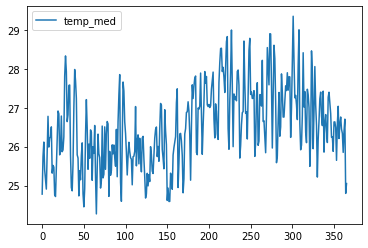

In [14]:
df_2008.plot(kind='line', y='temp_med');
plt.show()

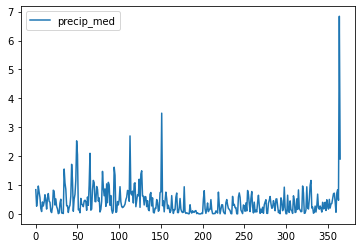

In [15]:
df_2008.plot(kind='line', y='precip_med');
plt.show()

In [16]:
#### Article parameters:

T_prime=19.9

T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.25
p_MP=0.75
tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737
D1=36.5
b1=0.04
A=-0.03
B=1.31
C=-4.4
b2=0.09
tau_H=10
DD=105
Tmin=14.5
gamma= 1/120
R_L = 50
N=8558
M= 10000  #0
E_M0=1 #0 # None
I_H0=1 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

# Defining the functions of temperature and precipitation
#def T(t):
#        return T1 * (1 + T2 * cos(omega1 * t - phi1))

#def R(t):
#        return R1 * (1 + R2 * cos(omega2 * t - phi2))

In [17]:
def Temp():
    return df_2008['temp_med']

def Rain():
    return df_2008['precip_med']

In [18]:
Temp()

0      24.7787
1      25.7396
2      26.1166
3      25.3995
4      25.1371
        ...   
361    25.8514
362    26.4017
363    26.7066
364    24.7968
365    25.0496
Name: temp_med, Length: 366, dtype: float64

In [19]:
Rain()

0      0.8388
1      0.2669
2      0.5316
3      0.9648
4      0.7522
        ...  
361    0.7252
362    0.8356
363    0.4734
364    6.8408
365    1.8999
Name: precip_med, Length: 366, dtype: float64

In [20]:
#### Testing for 2008 only

def original_model(t, z, df, B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
#     Temperature and rain functions
#     def Temp(t):
#         return T1 * (1 + T2 * cos(omega1 * t - phi1))

#     def Rain(t):
#         return R1 * (1 + R2 * cos(omega2 * t - phi2))

#     R_curr = Rain(t)
#     T_curr = Temp(t)
    
    # Get the closest integer day to use for indexing
    day_index = int(t)  

    if day_index >= len(df_2008):
        day_index = len(df_2008) - 1  # To avoid out-of-bounds issues
    
    T_curr = df_2008.loc[day_index, 'temp_med']
    R_curr = df_2008.loc[day_index, 'precip_med']
    
    # Duration of larval development phase
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Daily survival rate of mosquitoes
    def p(Temp):
        return np.exp(-1 / (A * Temp**2 + B * Temp + C))
    
    # Larval survival probability dependent on temperature and rain
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4 * p_ML / R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain, Temp):
        return p_LR(Rain) * p_LT(Temp)
    
    # Egg and pupa survival probability dependent on rain
    def p_ER(Rain):
        return (4 * p_ME / R_L**2) * Rain * (R_L - Rain)
    
    def p_PR(Rain):
        return (4 * p_MP / R_L**2) * Rain * (R_L - Rain)

    # Duration of the sporogonic cycle
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Defining the mosquito survival function
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Defining the mosquito mortality rate
    def mu(Temp):
        return -np.log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calculate the biting rate and transmission probability
    def a(Temp):
        return (Temp - T_prime) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain, Temp):
        return B_E * p_ER(Rain) * p_LRT(Rain, Temp) * p_PR(Rain) / (tau_E + tau_L(Temp) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt]

In [21]:
args = (df_2008, B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
        D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
        N, M, E_M0, I_H0)

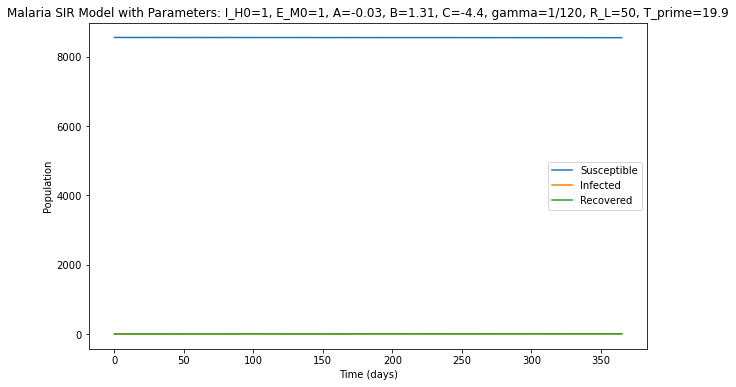

In [22]:
t_eval = np.linspace(0, 365, 1000)  # Evaluate the solution at 1000 points between 0 and 365
sol = solve_ivp(original_model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: I_H0={I_H0}, E_M0={E_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}')

plt.legend()

plt.show()

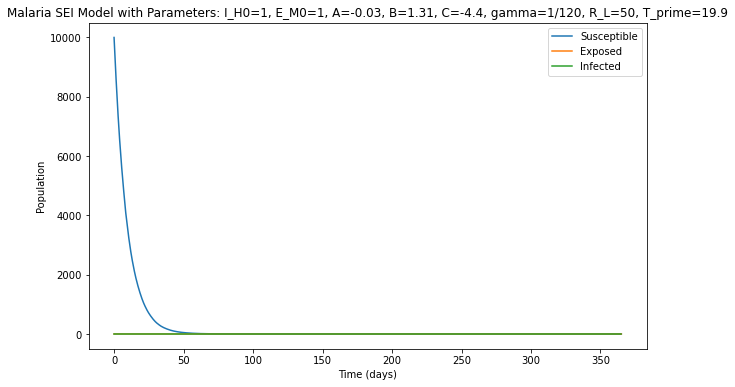

In [23]:
t_eval = np.linspace(0, 365, 1000)  # Evaluate the solution at 1000 points between 0 and 365
sol = solve_ivp(original_model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Susceptible')
plt.plot(times, E_M, label='Exposed')
plt.plot(times, I_M, label='Infected')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SEI Model with Parameters: I_H0={I_H0}, E_M0={E_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}')

plt.legend()

plt.show()

In [24]:
R_L = 450

In [25]:
args = (df_2008, B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
        D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
        N, M, E_M0, I_H0)

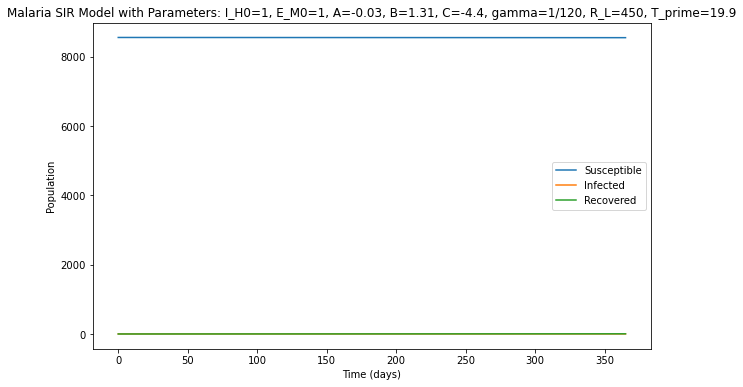

In [26]:
t_eval = np.linspace(0, 365, 1000)  # Evaluate the solution at 1000 points between 0 and 365
sol = solve_ivp(original_model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: I_H0={I_H0}, E_M0={E_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}')

plt.legend()

plt.show()

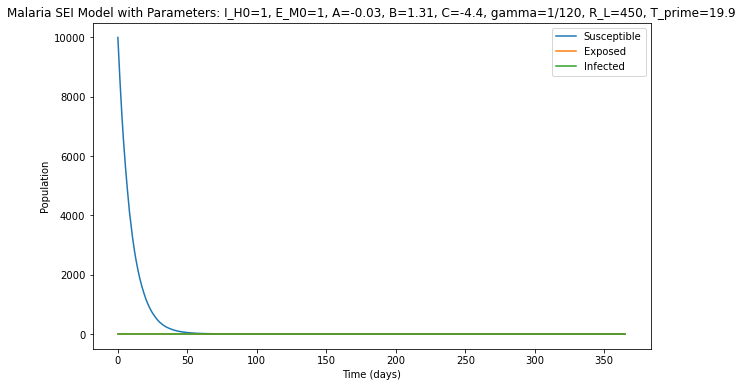

In [27]:
t_eval = np.linspace(0, 365, 1000)  # Evaluate the solution at 1000 points between 0 and 365
sol = solve_ivp(original_model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Susceptible')
plt.plot(times, E_M, label='Exposed')
plt.plot(times, I_M, label='Infected')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SEI Model with Parameters: I_H0={I_H0}, E_M0={E_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}')

plt.legend()

plt.show()

In [28]:
E_M0=5000 #0 # None
I_H0=1000

S_H0 = N - I_H0
S_M0 = M - E_M0

args = (df_2008, B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
        D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
        N, M, E_M0, I_H0)

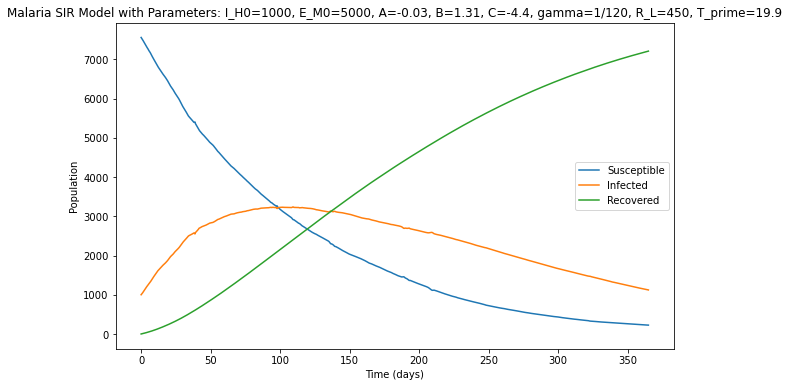

In [29]:
t_eval = np.linspace(0, 365, 1000)  # Evaluate the solution at 1000 points between 0 and 365
sol = solve_ivp(original_model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: I_H0={I_H0}, E_M0={E_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}')

plt.legend()

plt.show()

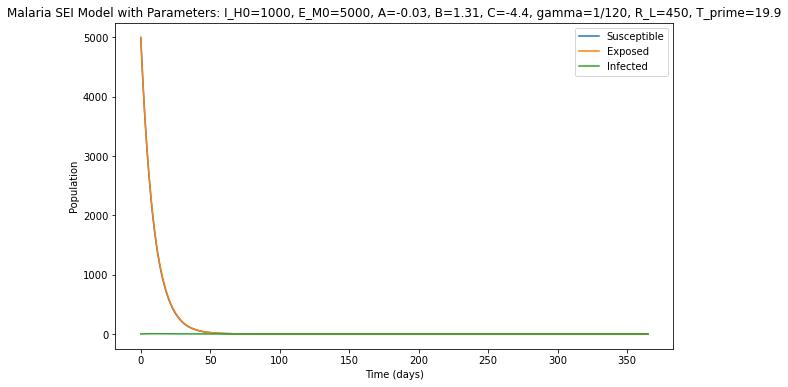

In [30]:
t_eval = np.linspace(0, 365, 1000)  # Evaluate the solution at 1000 points between 0 and 365
sol = solve_ivp(original_model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Susceptible')
plt.plot(times, E_M, label='Exposed')
plt.plot(times, I_M, label='Infected')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SEI Model with Parameters: I_H0={I_H0}, E_M0={E_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}')

plt.legend()

plt.show()

In [31]:
E_M0=1
I_H0=1

S_H0 = N - I_H0
S_M0 = M - E_M0

A = 12.5
B = 15.0
C = -48.78

args = (df_2008, B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
        D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
        N, M, E_M0, I_H0)

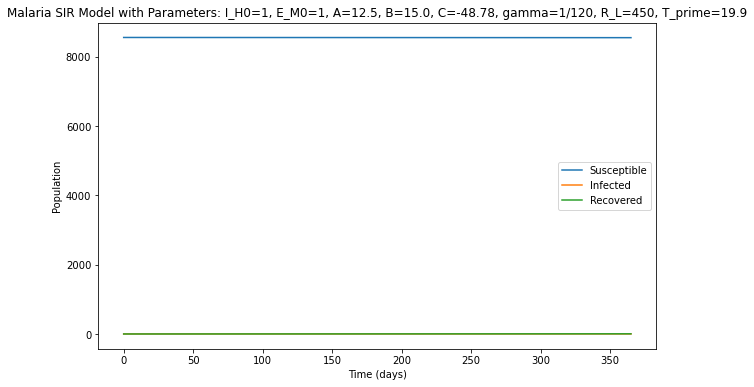

In [32]:
t_eval = np.linspace(0, 365, 1000)  # Evaluate the solution at 1000 points between 0 and 365
sol = solve_ivp(original_model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: I_H0={I_H0}, E_M0={E_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}')

plt.legend()

plt.show()

In [33]:
T_prime = 25.6

args = (df_2008, B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
        D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
        N, M, E_M0, I_H0)

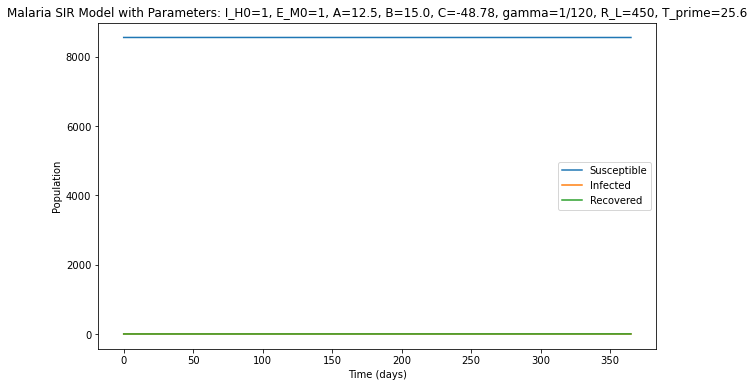

In [34]:
t_eval = np.linspace(0, 365, 1000)  # Evaluate the solution at 1000 points between 0 and 365
sol = solve_ivp(original_model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: I_H0={I_H0}, E_M0={E_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}')

plt.legend()

plt.show()

In [35]:
E_M0=5000 #0 # None
I_H0=1000

S_H0 = N - I_H0
S_M0 = M - E_M0

args = (df_2008, B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
        D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
        N, M, E_M0, I_H0)

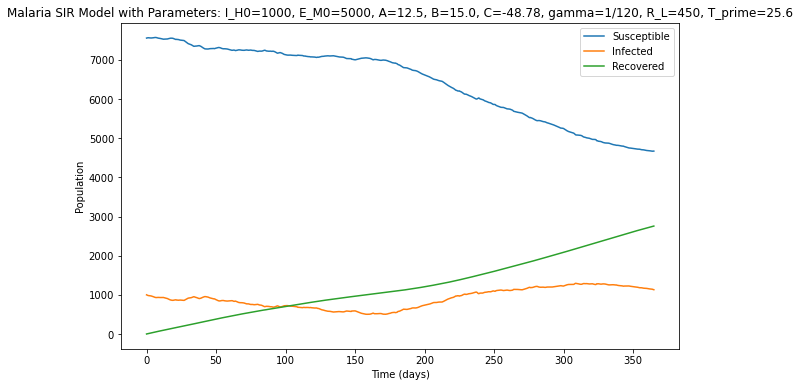

In [36]:
t_eval = np.linspace(0, 365, 1000)  # Evaluate the solution at 1000 points between 0 and 365
sol = solve_ivp(original_model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: I_H0={I_H0}, E_M0={E_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}')

plt.legend()

plt.show()

In [37]:
E_M0=50000 #0 # None
I_H0=1000

S_H0 = N - I_H0
S_M0 = M - E_M0

args = (df_2008, B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
        D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
        N, M, E_M0, I_H0)

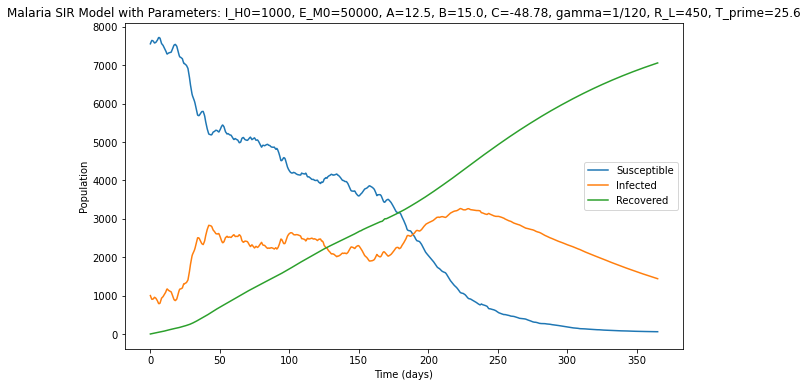

In [38]:
t_eval = np.linspace(0, 365, 1000)  # Evaluate the solution at 1000 points between 0 and 365
sol = solve_ivp(original_model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: I_H0={I_H0}, E_M0={E_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}')

plt.legend()

plt.show()